## Homework 2: Canny edge detector

The goal of the assignment is to implement a Canny edge detector. You should return the completed notebook, including answers and illustrations. 

If you are using [anaconda](https://www.anaconda.com/distribution/) you will have necessary libraries, if not, you may need to install them.

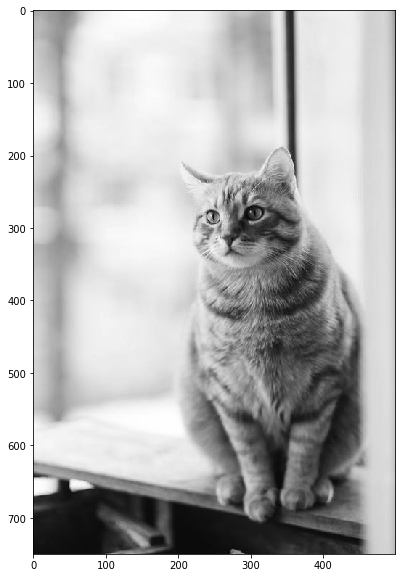

In [92]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.ndimage as ndimage #image processing library

# by default, the grayscale images are displayed with the jet colormap: use grayscale instead
plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

name = 'cat.jpeg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

## Step 1:
a- Compute a binary image corresponding to thresholding the norm of the gradient. You may use the function `ndimage.gaussian_filter` to compute the derivative of gaussian filter (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)). Discuss the parameters (there are two) and their influence on the results.

In [2]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import filters

In [3]:
def compute_gradient(img,sigma,threshold=0):
    '''
    Inputs: input image, sigma and threshold parameter
    Outputs: g_norm - thresholded norm of the gradient, g_theta - gradient orientation
    '''
    Gx = gaussian_filter(img, sigma, order = [0,1])
    Gy = gaussian_filter(img, sigma, order = [1,0])
    
    #Calculate normalized G and direction of the gradient
    g_norm = np.sqrt(np.square(Gx) + np.square(Gy))
    g_theta = np.arctan(Gy/Gx)
    
    #Use threshold to determine which pixel should be considered as an edge pixel
    g_norm[g_norm < threshold] = 0
    
    return g_norm, g_theta

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


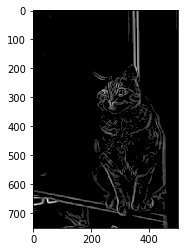

In [98]:
g_norm, _ = compute_gradient(img, 2, 5)
plt.imshow(g_norm)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


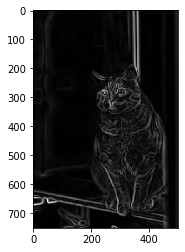

In [95]:
g_norm, _ = compute_gradient(img, 2)
plt.imshow(g_norm)

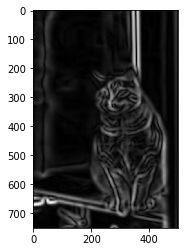

In [96]:
g_norm, _ = compute_gradient(img, 5)
plt.imshow(g_norm)

In this step, we takes two paramsters, sigma and threshold. Sigma is the parameter for the gaussion filter, it determines how much we want to smooth out the noise inside of the image. The parameter threshold controls when do we consider a pixel as edge pixel. When trying out different value of sigma, larger sigma will give sharper gaussian and result in thicker edges because noises are not smoothed ideally. When I compare resulting images with sigma = 1 and sigma = 5, I can see that image with high sigma is blurer and because of the noises are not smoothed as much, the gradient is still pretty high for some of the pixels. Threshold also controls how much detail we can see from the original image. I compared the resulting images with threshold = 1 and threshold = 10, the most significant change is how the fur details disappear with a high threshold. Threshold is different to sigma in that it does not controls based on smoothness.

## Step 2:
b- Write a function `nms(g_norm,g_theta)` which takes as input the gradient norm and direction and outputs a binary images with value 1 only for pixels that correspond to a maximum in the direction of the gradient.

In [81]:
def non_max_suppression(g_norm, g_theta):
    g_theta = np.rad2deg(g_theta)
    g_theta += 180
    
    M, N = g_norm.shape
 
    output = np.zeros(g_norm.shape)
 
    PI = 180
    
    
    # Here we are just dividing up the zones of angles for each neighbor
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            
            direction = g_theta[i, j]

            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                p = g_norm[i, j - 1]
                r = g_norm[i, j + 1]

            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                p = g_norm[i - 1, j - 1]
                r = g_norm[i + 1, j + 1]

            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                p = g_norm[i - 1, j]
                r = g_norm[i + 1, j]

            else:
                p = g_norm[i + 1, j - 1]
                r = g_norm[i - 1, j + 1]
                

            if g_norm[i, j] >= p and g_norm[i, j] >= r:
                output[i, j] = g_norm[i, j]

    return output

## Step 3:
c- Combine 'a' and 'b' to extract edges with a gradient norm larger than a given threshold.

In [34]:
def threshold(img,highThreshold,lowThreshold):
    '''
    Inputs: img - image processes with non-max supression, 
            highThreshold,lowThreshold - high and low threshodl ratios
    Outputs: res - output image, weak, strong - pixel values assiged to weak and strong images
    '''
    # Because the given parameters are ratios, we need to calculate the real thresholds
    high = highThreshold * np.max(img)
    low = lowThreshold * high
    
    # The values we want to set for strong and weak pixels in grascale
    strong = 255
    weak = 55
    
    res = np.zeros(img.shape)
    
    # Get back the coordinates of pixels that satisfy the threshold, and the rest of the values should be zero
    strong_x, strong_y = np.where(img > high)
    weak_x, weak_y = np.where((img <= high) & (img > low))
    
    res[strong_x, strong_y] = strong
    res[weak_x, weak_y] = weak

    return (res, weak, strong)

## Step 4:
d- Add the hysteresis thresholding to step 'c' to implement a function computing the Canny edges.

Here is one way to do the hysteresis thresholding. Apply step c with two thresholds $t_1 < t_2$. This yields a set of "strong pixels" (large threshold) and "weak pixels" (small threshold). Initialize a list of edge pixels by including only the set of strong pixels. For each pixel in this list, check if its neighboors are weak pixels. If they are, add them to the list of pixels to visit.

In [37]:
def hysteresis(img, weak, strong):
    '''
    Inputs: res - thresholded NMS image, 
    weak, strong - pixel values assiged to weak and strong images
    
    Outputs: img - result after hysteresis
    '''
    
    # Here we follow the description given by the problem. I used a queue structure here (first in first out), to 
    #keep track how many items do we left to check
    
    queue = []
    
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            if (img[i,j] == strong):
                queue.append((i,j))
                
                
    # Here we do not need to worry about th edge cases because we set all pixels in the corner and edge to be zero
    #while doing non-max-supression
    
    while len(queue) != 0:
        
        i, j = queue[0]
        
        if img[i+1, j-1] == weak:
            img[i+1, j-1] = strong
            queue.append((i+1, j-1))
        
        if img[i+1, j] == weak:
            img[i+1, j] = strong
            queue.append((i+1, j))
        
        if img[i+1, j+1] == weak:
            img[i+1, j+1] = strong
            queue.append((i+1, j+1))
        
        if img[i, j-1] == weak:
            img[i, j-1] = strong
            queue.append((i, j-1))
        
        if img[i, j+1] == weak:
            img[i, j+1] = strong
            queue.append((i, j+1))
        
        if img[i-1, j-1] == weak:
            img[i-1, j-1] = strong
            queue.append((i-1, j-1))
            
        if img[i-1, j] == weak:
            img[i-1, j] = strong
            queue.append((i-1, j))
            
        if img[i-1, j+1] == weak:
            img[i-1, j+1] = strong
            queue.append((i-1, j+1))
        
        queue.pop(0)
    
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            if (img[i,j] == weak):
                img[i,j] = 0
    
    return img

## Step 5:
e- Run your code on at least four images of your own choosing. Use different parameters and comment on their effects.

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


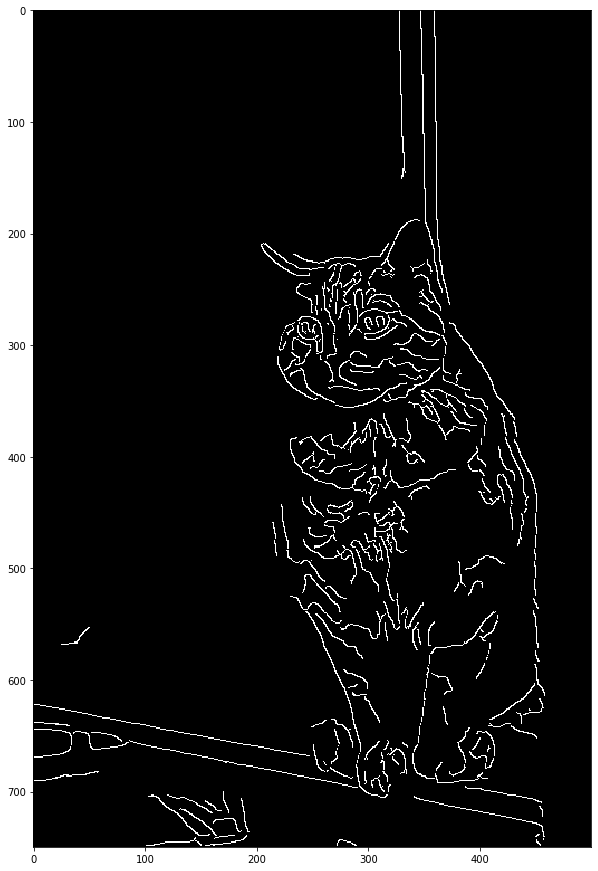

In [86]:
# parameters to check
sigma=2
lowThreshold=0.09
highThreshold=0.2
weak_pixel=100
strong_pixel=255


gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

### Trying the dog image

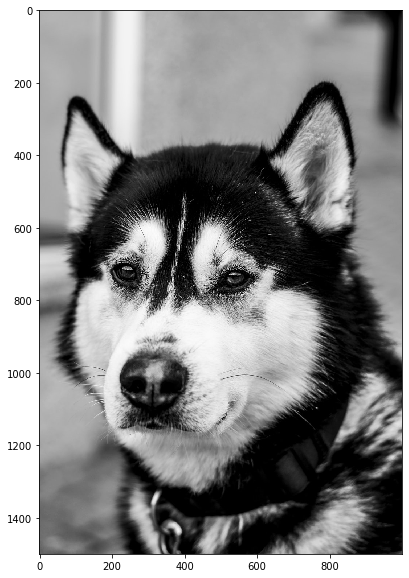

In [118]:
# This image is from dowloaded from google search dog, and the source linke is https://unsplash.com/s/photos/dogs
name = 'dog.jpeg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


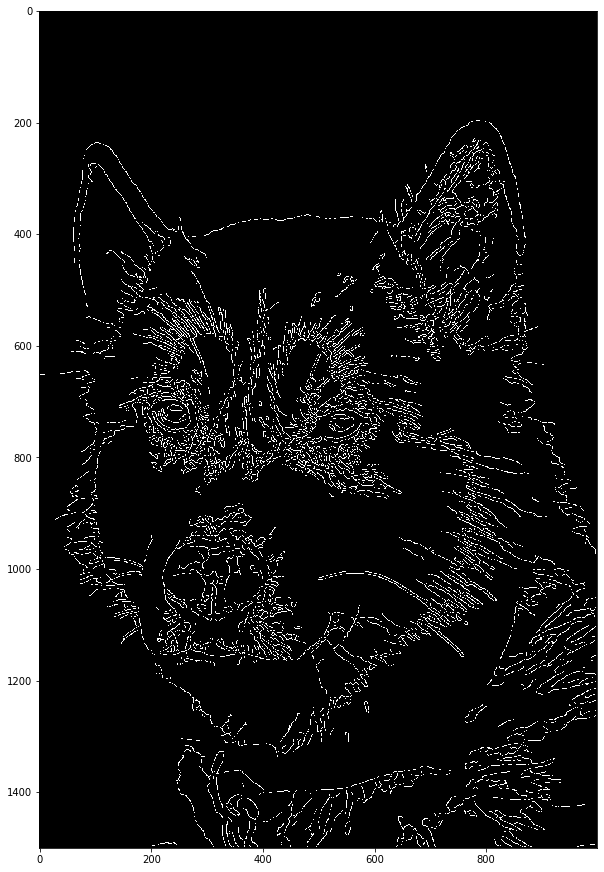

In [119]:
sigma=2
lowThreshold=0.09
highThreshold=0.2
weak_pixel=100
strong_pixel=255

gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


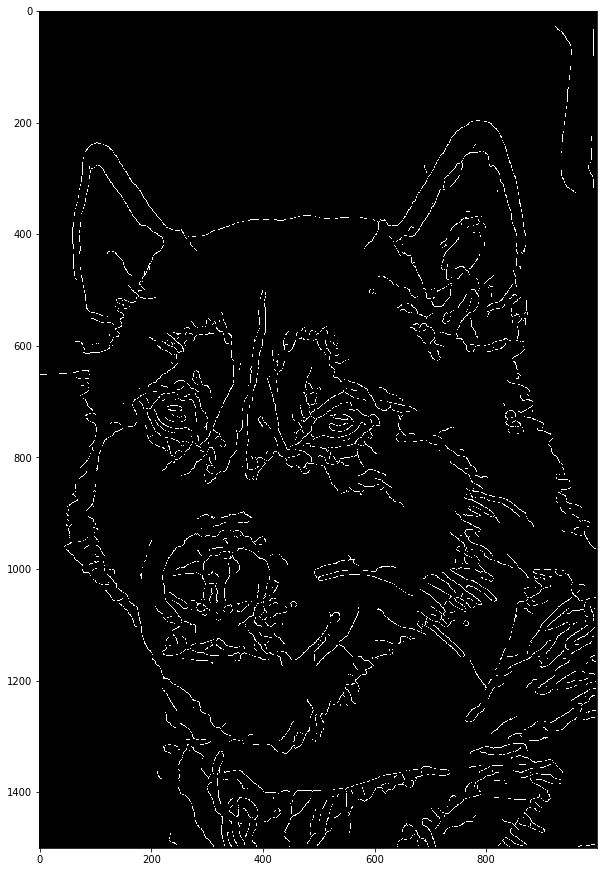

In [120]:
sigma=4
lowThreshold=0.09
highThreshold=0.2
weak_pixel=100
strong_pixel=255

gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


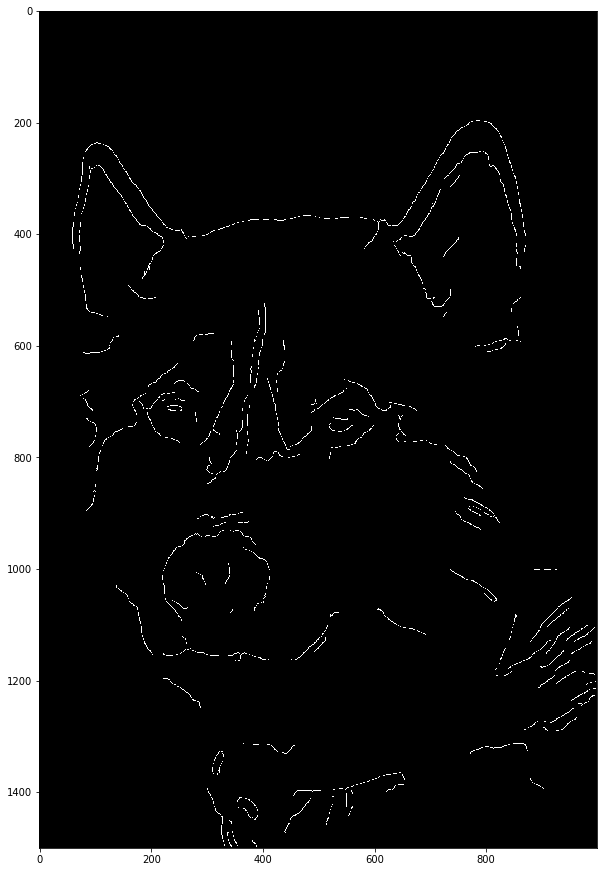

In [121]:
sigma=4
lowThreshold=0.09
highThreshold=0.5
weak_pixel=100
strong_pixel=255

gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

Because for this dog picture, it has a rather high noise because of the fur, thus I use high high threshold to capture more of the overall contour than details. But if we lower this value, then the edge are more detailed because of the fur texture. I used a pretty high threshold then, and results in a more rough contour. I also adjusted the sigma value for this dog picture as well. We know that the higher sigma is, the blurrer the image are and the thicker the edge will be. 

### Trying car picture

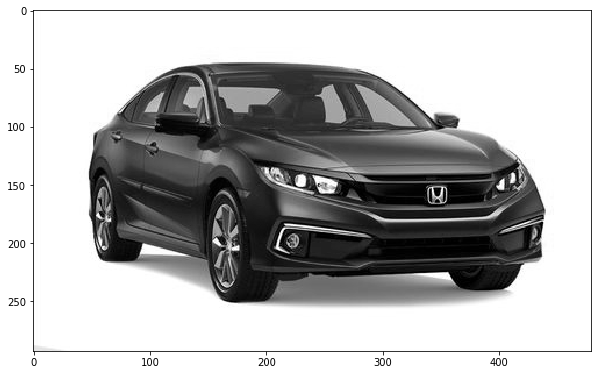

In [110]:
# The image is downloaded from google search of car, and the source linke is https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/2019-honda-civic-sedan-1558453497.jpg?crop=1xw:0.9997727789138833xh;center,top&resize=480:*
name = 'car.jpg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


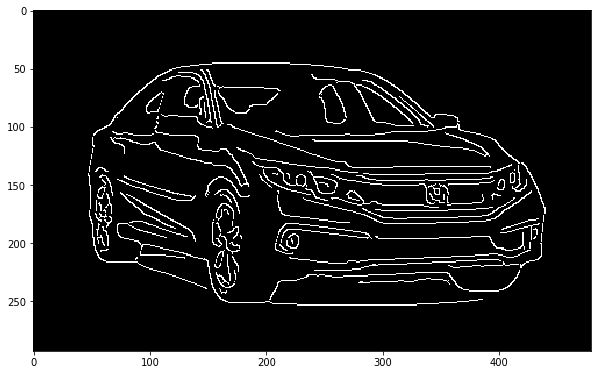

In [111]:
sigma=2
lowThreshold=0.09
highThreshold=0.2
weak_pixel=100
strong_pixel=255

gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


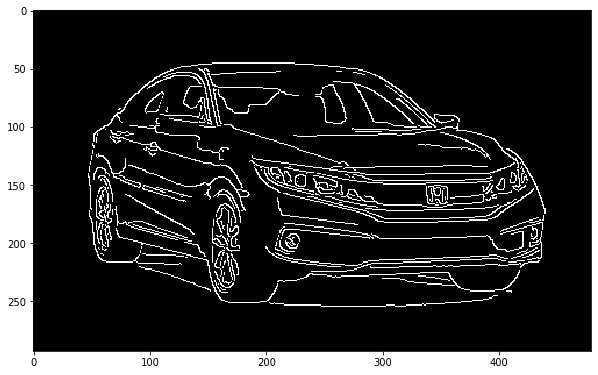

In [101]:
sigma=1
lowThreshold=0.09
highThreshold=0.2
weak_pixel=100
strong_pixel=255

gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

For the car image, I purposefully chose a picture that is very clear, and thus we can see that our result is very complete as a car. For this image, I changed the sigma to be a lower value, and I found that if I use sigma = 2, I will not be able to see the honda sign clear, but now with sigma = 1, we can see clear that this car is a honda car with the sign with out the thick edge problem. 

### Trying Clock Picture

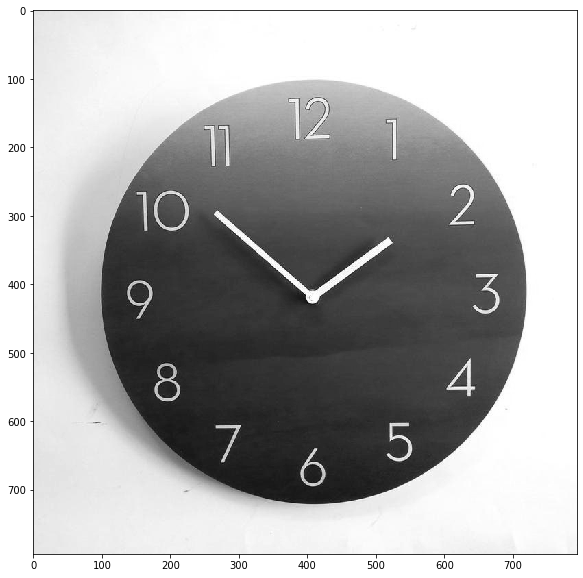

In [102]:
# This image is downloaded from google search of clock, and the link is https://media.architecturaldigest.com/photos/608c466e59e3e3029845b66c/1:1/w_794,h_794,c_limit/Objectify-Ombre-Teal-Wall-Clock-With-Neutra-Numerals.jpg
name = 'clock.jpg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


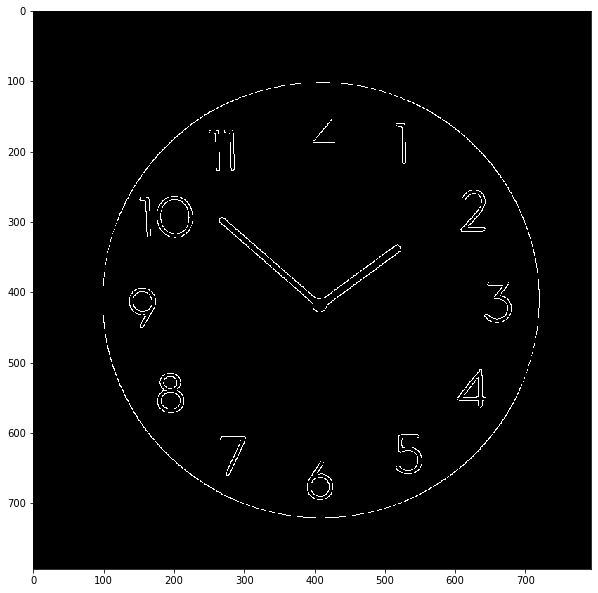

In [108]:
sigma=2
lowThreshold=0.02
highThreshold=0.4
weak_pixel=100
strong_pixel=255

gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


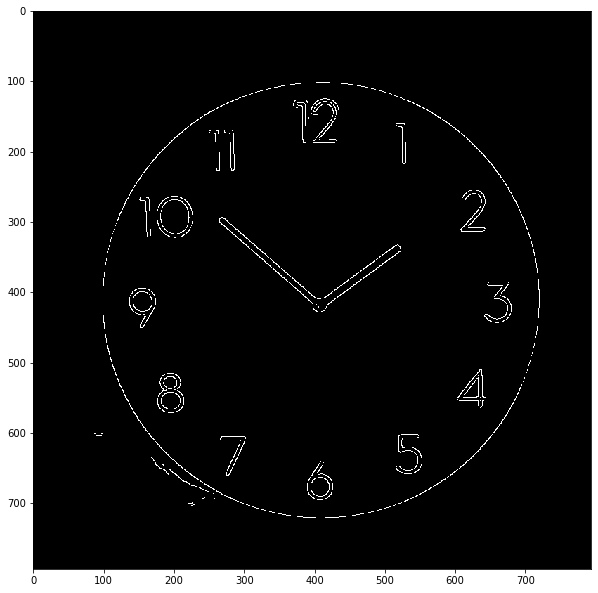

In [105]:
sigma=2
lowThreshold=0.02
highThreshold=0.1
weak_pixel=100
strong_pixel=255

gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


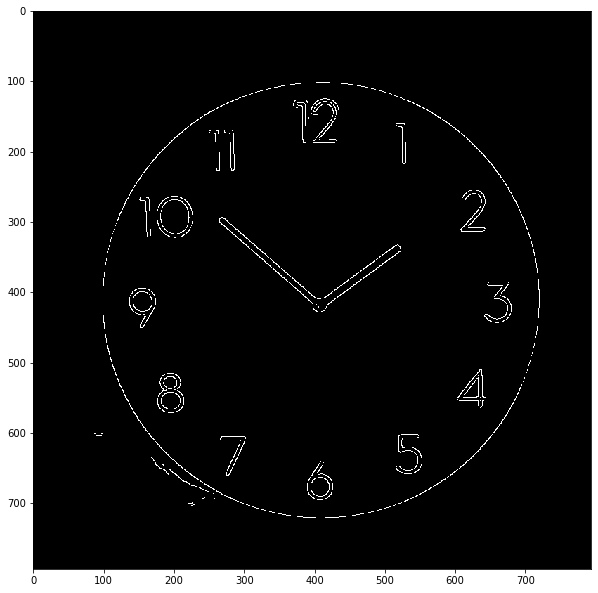

In [106]:
sigma=2
lowThreshold=0.09
highThreshold=0.1
weak_pixel=100
strong_pixel=255

gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

I choose this clock image because I want to see if the numbers can be detected clearly and completely. That is I am expecting to see whole figures. Thus, here I change the high and low threshold to see if we can better detect the numbers and the straigt line of the pointers. Because this image, not like dog and cat, has pretty clear edge, thus, here I choose to use a lower high threshold to see if we can capture all the edges for the numbers and pointers. We can see that if we have a high high threshold, the numbers and pointers are less connected. But I found that changing the low threshold does not cause much difference, which I think is because this image does not have much noisy details.

### Trying mountain image

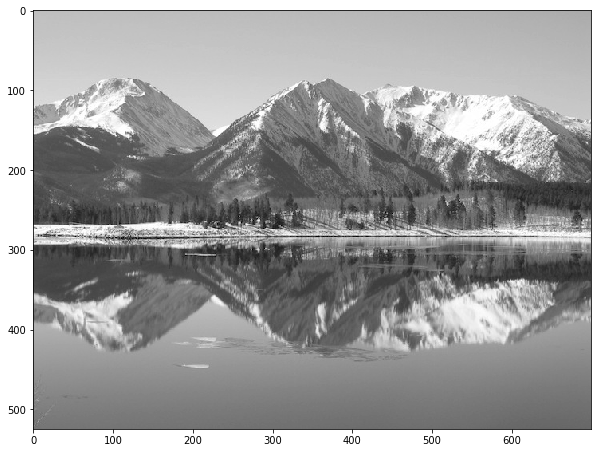

In [112]:
# This image is downloaded from google search of mountain, and its link is https://dfv6pkw99pxmo.cloudfront.net/wp-content/uploads/2018/07/colorado-moutain.jpg
name = 'moutain.jpg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

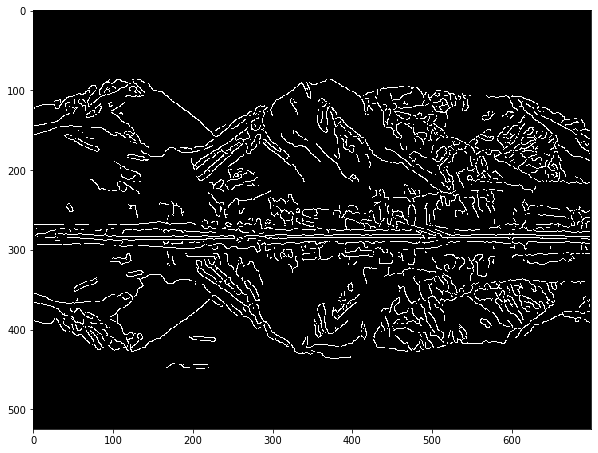

In [113]:
sigma=2
lowThreshold=0.09
highThreshold=0.2
weak_pixel=100
strong_pixel=255

gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

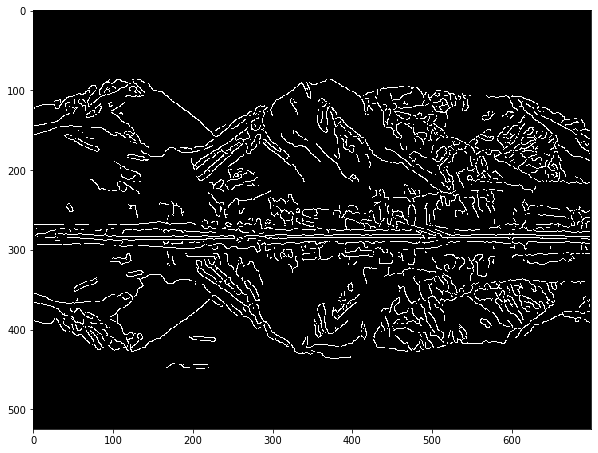

In [114]:
sigma=2
lowThreshold=0.09
highThreshold=0.2
weak_pixel=10
strong_pixel=255

gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

I choose this image because I am curious about the reflection. We can see that because the reflection is more blurred than the actual moutain, and thus, for reflection, our detected edges are less detailed. Here I tried changing the weak value, which seems to have no effect. This makes sense because weak is value that assigned to differentiate the strong pixels. 